# Trying a Hurdle Model with XGBoost

In [1]:
# Load the data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import collections
import seaborn as sns

df = pd.read_csv('~/Downloads/eurovision_merged_covariates_03Feb.csv')

In [2]:
df.head()

,Unnamed: 0,Year,From country,Votes,Country,Own,English,Other,has_border,migration_band,migration_year,code,code3,population,count,prop_emigrants,Gender,comps_since_last_win
0,0,1999,AT,12.0,Bosnia and Herzegovina,0.0,0.0,1.0,NaN,2000,2000,BA,BIH,4179350.0,273,0.000065,group,43
1,1,1999,AT,0.0,Belgium,0.0,1.0,0.0,NaN,2000,2000,BE,BEL,10251250.0,2486,0.000243,female,12
2,2,1999,AT,0.0,Cyprus,1.0,0.0,0.0,NaN,2000,2000,CY,CYP,948237.0,161,0.000170,female,43
3,3,1999,AT,10.0,Germany,0.0,0.0,1.0,1.0,2000,2000,DE,DEU,82211508.0,181487,0.002208,group,16
4,4,1999,AT,5.0,Denmark,0.0,1.0,0.0,NaN,2000,2000,DK,DNK,5339616.0,1525,0.000286,group,35


In [3]:
df.loc[(df['Year'] == 2004) & (df['From country'] == 'GB')].shape

(18, 18)

# XGBoost to predict if score given

First step in the hurdle model.

Example: https://www.kaggle.com/code/sriharinitumu/light-gbm-with-hurdle-modelling

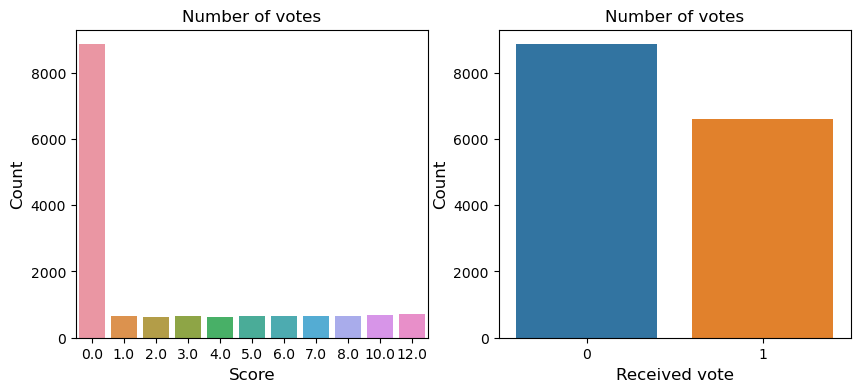

In [4]:
df['received_vote'] = df['Votes'].apply(lambda x: 1 if x > 0 else 0)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))


# Bar chart for vote occurrences
sns.countplot(x="Votes", data=df, ax=ax1)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_xlabel('Score', fontsize=12)
ax1.set_title('Number of votes', fontsize=12)

sns.countplot(x="received_vote", data=df, ax=ax2)
ax2.set_ylabel('Count', fontsize=12)
ax2.set_xlabel('Received vote', fontsize=12)
ax2.set_title('Number of votes', fontsize=12)

plt.show()


As you can see we have a lot of zeroes....this probably makes this problem appropriate for a hurdle model. Where we first decide if a score is given, and then if it is, we predict the score.

/var/folders/c2/_b9mpch10xs9cgrc8sq6fhfm0000gr/T/ipykernel_93674/617021266.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xgboost['has_border'] = df_xgboost['has_border'].fillna(0)
/var/folders/c2/_b9mpch10xs9cgrc8sq6fhfm0000gr/T/ipykernel_93674/617021266.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xgboost['prop_emigrants'] = df_xgboost['prop_emigrants'].apply(lambda x: np.log10(x+4e-8))
/var/folders/c2/_b9mpch10xs9cgrc8sq6fhfm0000gr/T/ipykernel_93674/617021266.py:19: SettingWithCopyWar

<AxesSubplot:>

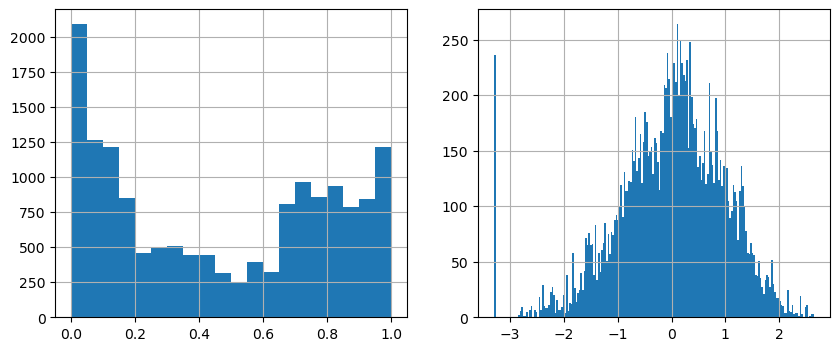

In [5]:
# scale some of the features

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


df_xgboost = df[['Year', 'From country', 'Votes', 'Own', 'English', 'Other', 
                 'has_border', 'code', 'prop_emigrants', 'Gender', 
                 'comps_since_last_win', 'received_vote']]

df_xgboost['has_border'] = df_xgboost['has_border'].fillna(0)

# log10 scale the prop_emigrants column
df_xgboost['prop_emigrants'] = df_xgboost['prop_emigrants'].apply(lambda x: np.log10(x+4e-8))


# apply the standard scaler to prop_emigrants and comps_since_last_win
scaler = StandardScaler()
df_xgboost[['prop_emigrants']] = scaler.fit_transform(df_xgboost[['prop_emigrants']])

scaler = MinMaxScaler()
df_xgboost[['comps_since_last_win']] = scaler.fit_transform(df_xgboost[['comps_since_last_win']])


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# histogram of the log scaled prop_emigrants column
df_xgboost['comps_since_last_win'].hist(bins=20, ax=ax1)
df_xgboost['prop_emigrants'].hist(bins=200, ax=ax2)

In [6]:
df['Votes']

0        12.0
1         0.0
2         0.0
3        10.0
4         5.0
         ... 
15447     6.0
15448     1.0
15449    12.0
15450     0.0
15451     0.0
Name: Votes, Length: 15452, dtype: float64

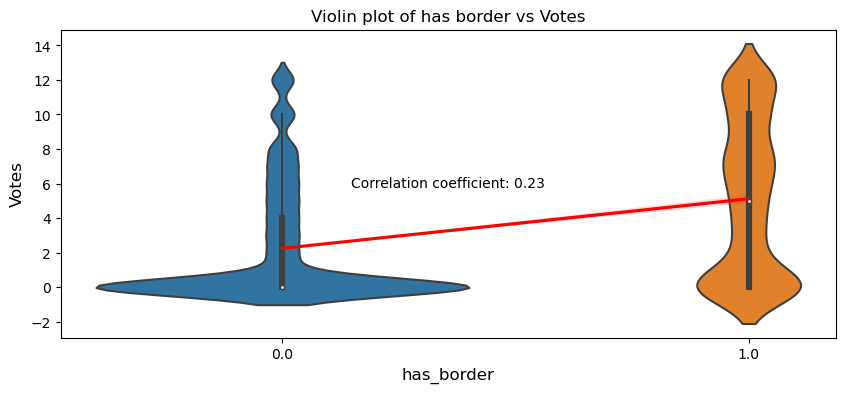

In [7]:
# violin plot of has_border vs received_vote

val="Votes"

fig, ax = plt.subplots(figsize=(10, 4))
sns.violinplot(x="has_border", y=val, data=df_xgboost, ax=ax)
ax.set_ylabel(val, fontsize=12)
ax.set_xlabel('Has border', fontsize=12)
ax.set_title('Violin plot of has border vs ' + val, fontsize=12)

# add best fit line
sns.regplot(x="has_border", y=val, data=df_xgboost, ax=ax, scatter=False, color='red')

# add correlation coefficient
corr = df_xgboost['has_border'].corr(df_xgboost[val])
ax.text(0.5, 0.5, 'Correlation coefficient: {:.2f}'.format(corr), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)


plt.show()


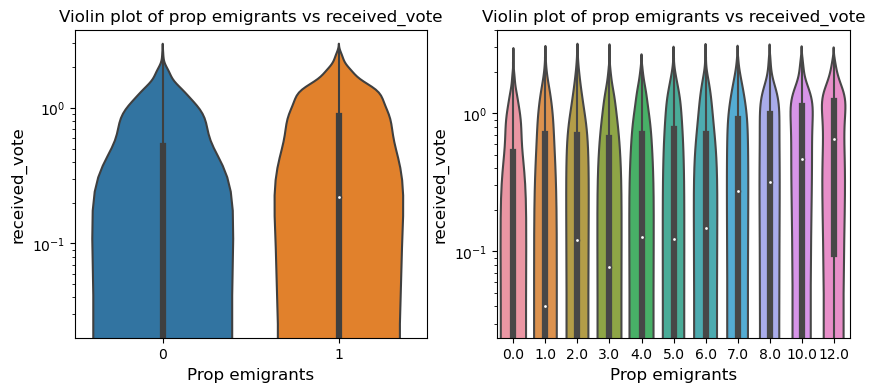

In [8]:
# violin plot of prop emigranges vs received_vote

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))


val="received_vote"

#fig, ax = plt.subplots(figsize=(10, 4))
sns.violinplot(y="prop_emigrants", x=val, data=df_xgboost, ax=ax1)
ax1.set_ylabel(val, fontsize=12)
ax1.set_xlabel('Prop emigrants', fontsize=12)
ax1.set_title('Violin plot of prop emigrants vs ' + val, fontsize=12)

# log scale the prop emigrants
ax1.set_yscale('log')

sns.violinplot(y="prop_emigrants", x="Votes", data=df_xgboost, ax=ax2)
ax2.set_ylabel(val, fontsize=12)
ax2.set_xlabel('Prop emigrants', fontsize=12)
ax2.set_title('Violin plot of prop emigrants vs ' + val, fontsize=12)
ax2.set_yscale('log')

# # add best fit line
# sns.regplot(x="prop_emigrants", y=val, data=df_xgboost, ax=ax, scatter=False, color='red')

# # add correlation coefficient
# corr = df_xgboost['prop_emigrants'].corr(df_xgboost[val])
# ax.text(0.5, 0.5, 'Correlation coefficient: {:.2f}'.format(corr), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

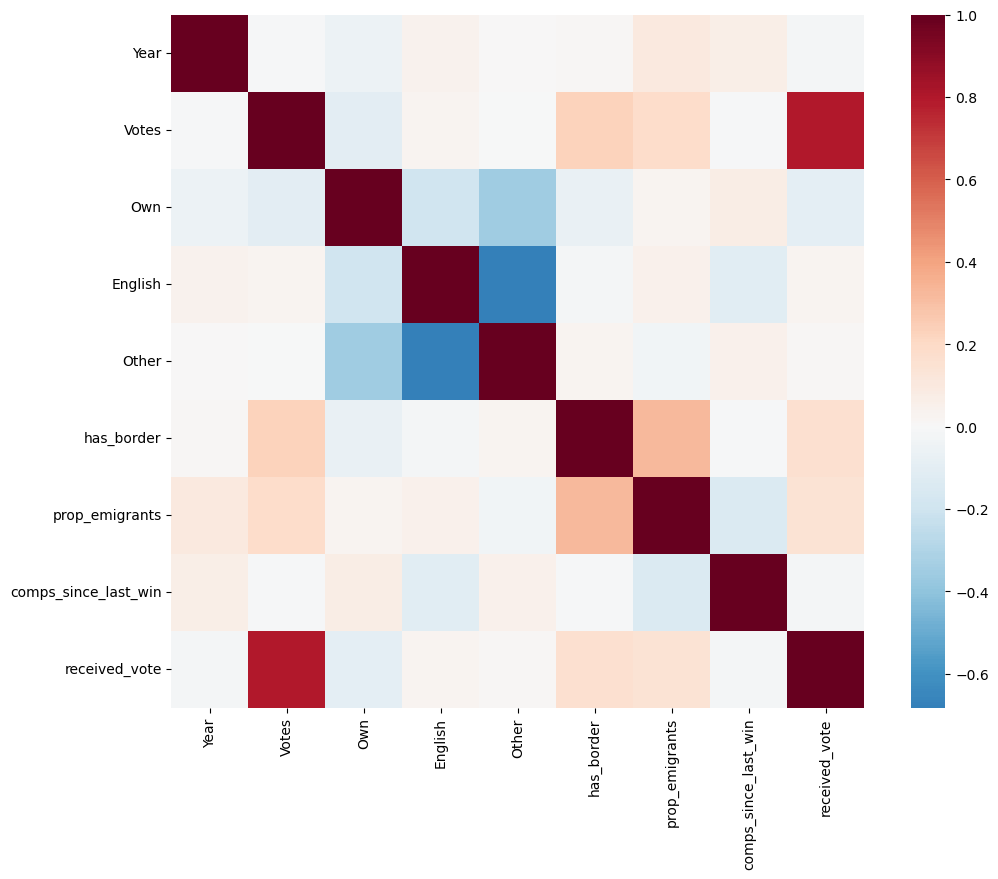

In [9]:
# correlation matrix for the numeric features

corrmat = df_xgboost.corr()

# replace 1 with NA
#corrmat[corrmat > 0.75] = np.nan

f, ax = plt.subplots(figsize=(12, 9))


# red blue colour scale
sns.heatmap(corrmat, center=0, square=True, cmap="RdBu_r", ax=ax)
plt.show()

In [10]:
# import the xgboost_functions.py file
import xgboost_functions as xgbf

/Users/kgoldmann/Documents/Projects/TDS/Eurovision_TDS/xgboost_functions.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[i+j_text] = output_binary
/Users/kgoldmann/Documents/Projects/TDS/Eurovision_TDS/xgboost_functions.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[i+j_text] = output_binary
/Users/kgoldmann/Documents/Projects/TDS/Eurovision_TDS/xgboost_functions.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

Accuracy: 75.35%


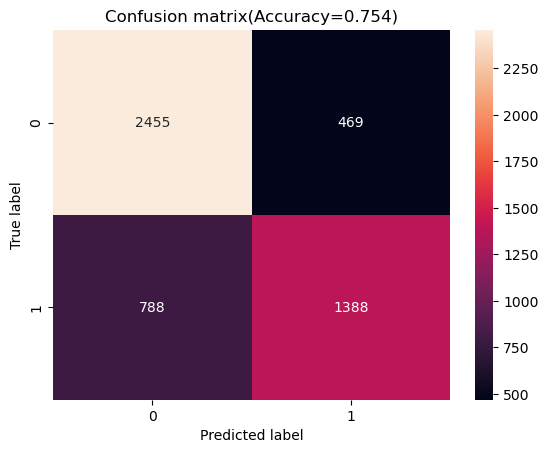

In [11]:
model_basic, X_test, y_test, test_all = xgbf.basic_xgboost(df_xgboost, seed=7, test_size=0.33)
predictions = xgbf.model_predictions(model_basic, X_test, y_test)
xgbf.model_evalutation(predictions)

To view variable importance we can take a peak at the tree:

<AxesSubplot:>

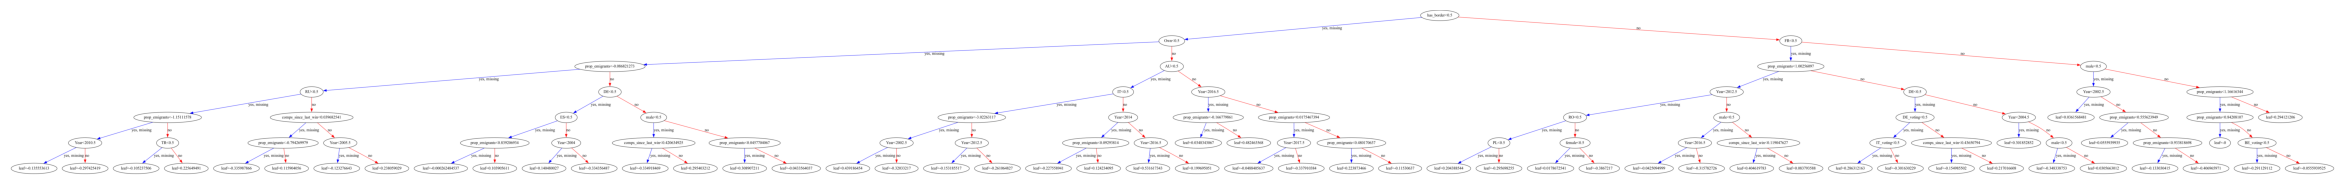

In [12]:
import matplotlib
import xgboost as xgb

graph = xgb.to_graphviz(model_basic, num_trees=1, rankdir='LR')

fig, ax = plt.subplots(figsize=(30, 50))
xgb.plot_tree(model_basic, num_trees=1, ax=ax)

First node = has_border !

## Ranking Score

So of those, lets subset to only those that have a score.

In [13]:
df_xgboost.head()

,Year,From country,Votes,Own,English,Other,has_border,code,prop_emigrants,Gender,comps_since_last_win,received_vote
0,1999,AT,12.0,0.0,0.0,1.0,0.0,BA,-0.376727,group,0.682540,1
1,1999,AT,0.0,0.0,1.0,0.0,0.0,BE,0.141040,female,0.190476,0
2,1999,AT,0.0,1.0,0.0,0.0,0.0,CY,0.000310,female,0.682540,0
3,1999,AT,10.0,0.0,0.0,1.0,1.0,DE,1.013074,group,0.253968,1
4,1999,AT,5.0,0.0,1.0,0.0,0.0,DK,0.205615,group,0.555556,1


In [14]:
test_all.head()

,Year,Own,English,Other,has_border,prop_emigrants,Votes,received_vote,comps_since_last_win,group,...,BG,GE,RS,BY,AZ,IT,ME,SM,AU,MK
13486,2017,0.0,1.0,0.0,0.0,-0.548240,3.0,1,0.476190,0,...,0,0,0,0,0,0,0,0,0,0
11265,2015,1.0,0.0,0.0,0.0,-0.089586,0.0,0,0.587302,0,...,0,0,0,0,0,0,0,0,0,0
526,2000,1.0,1.0,0.0,0.0,0.173049,0.0,0,0.031746,0,...,0,0,0,0,0,0,0,0,0,0
12497,2016,1.0,1.0,0.0,0.0,1.226200,0.0,0,0.285714,0,...,0,0,0,0,0,0,0,0,0,0
15011,2019,0.0,1.0,0.0,0.0,0.749997,4.0,1,0.682540,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
model_ranked, test_data, train_data = xgbf.xgboost_rank_model(df_xgboost.loc[df_xgboost['Votes'] > 0], seed=7, test_size=0.33)
out = xgbf.ranked_model_predictions(model_ranked, test_data)

/Users/kgoldmann/Documents/Projects/TDS/Eurovision_TDS/xgboost_functions.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['has_border'] = df2['has_border'].fillna(0)


Accuracy: 15.53%


In [16]:
out['predictions'].value_counts()

8.0     253
12.0    253
7.0     253
10.0    253
6.0     251
5.0     247
4.0     238
3.0     205
2.0     157
1.0      71
0.0       8
Name: predictions, dtype: int64

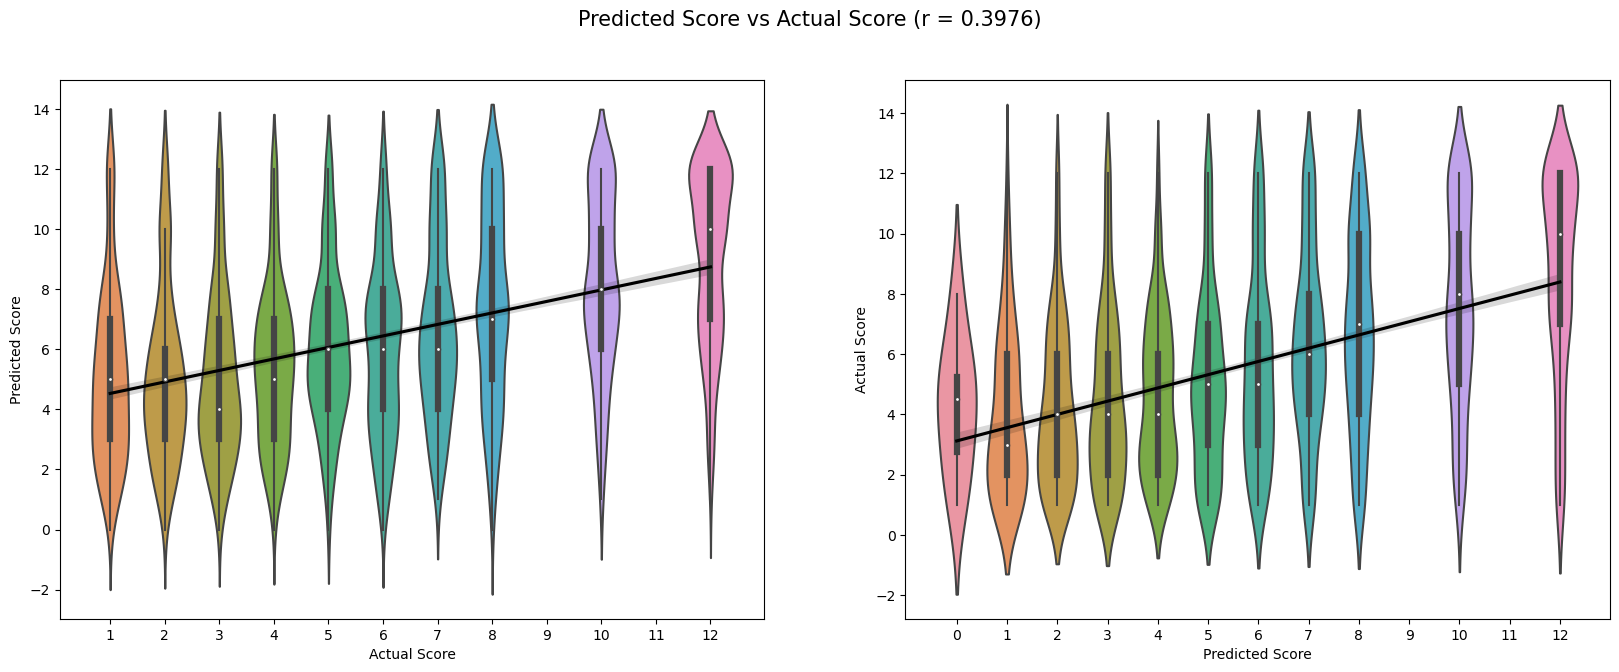

In [17]:
xgbf.violins(out)

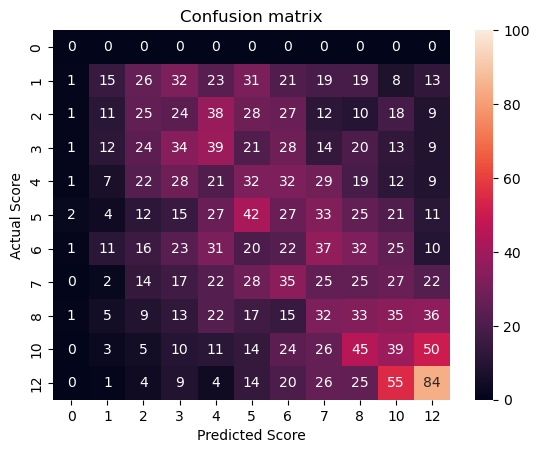

In [18]:
xgbf.cm_heatmap(out)

See [here](https://discuss.xgboost.ai/t/evaluating-xgboost-ranking/959/2) for description of prediction scores

The 0 predictions are coming up when we have more that 10 non-zeroes (due to draws). So this actually works quite well I think. 

## Quickly see how this compares to a non pairwise rank model

/var/folders/c2/_b9mpch10xs9cgrc8sq6fhfm0000gr/T/ipykernel_93674/2521976776.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_votes['Votes2'] = df_votes["Votes"] - 1
/var/folders/c2/_b9mpch10xs9cgrc8sq6fhfm0000gr/T/ipykernel_93674/2521976776.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_votes['Votes2'] = df_votes['Votes2'].apply(lambda x: 8 if x == 9 else x)
/var/folders/c2/_b9mpch10xs9cgrc8sq6fhfm0000gr/T/ipykernel_93674/2521976776.py:5: SettingWithCopyWarning: 
A value is trying to be set on

Accuracy: 14.80%


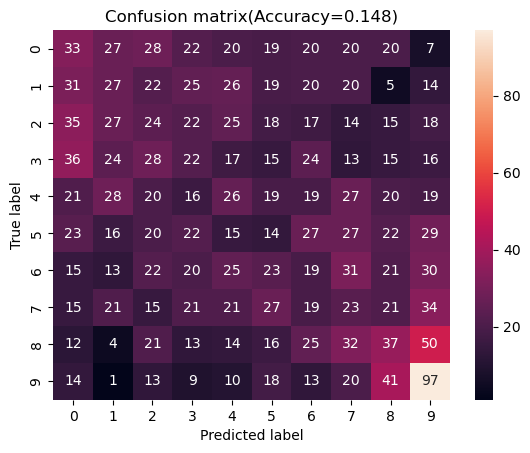

In [19]:
df_votes = df_xgboost.loc[df_xgboost['Votes'] > 0]

df_votes['Votes2'] = df_votes["Votes"] - 1
df_votes['Votes2'] = df_votes['Votes2'].apply(lambda x: 8 if x == 9 else x)
df_votes['Votes2'] = df_votes['Votes2'].apply(lambda x: 9 if x == 11 else x)

model, X_test, y_test, t2 = xgbf.basic_xgboost(df_votes, seed=7, test_size=0.33, predictor_column='Votes2')
predictions = xgbf.model_predictions(model, X_test, y_test)
xgbf.model_evalutation(predictions)

In [20]:
predictions.head()

,Year,Own,English,Other,has_border,prop_emigrants,comps_since_last_win,group,female,male,...,BY,GE,AZ,IT,ME,SM,AU,MK,predictions,actual
8242,2011,0.0,0.0,1.0,0.0,-0.459785,0.317460,0,0,1,...,0,0,0,1,0,0,0,0,2,9
12166,2016,1.0,1.0,0.0,0.0,0.159639,0.952381,0,1,0,...,0,0,0,0,0,0,0,0,2,2
14089,2018,0.0,0.0,1.0,0.0,1.040878,0.984127,0,1,0,...,0,0,0,0,0,0,0,0,9,6
5846,2008,0.0,1.0,0.0,1.0,0.507835,0.825397,0,0,1,...,0,0,0,0,0,0,0,0,9,9
11552,2015,0.0,0.0,1.0,0.0,-0.947467,0.111111,0,1,0,...,0,0,0,0,0,0,0,0,2,1


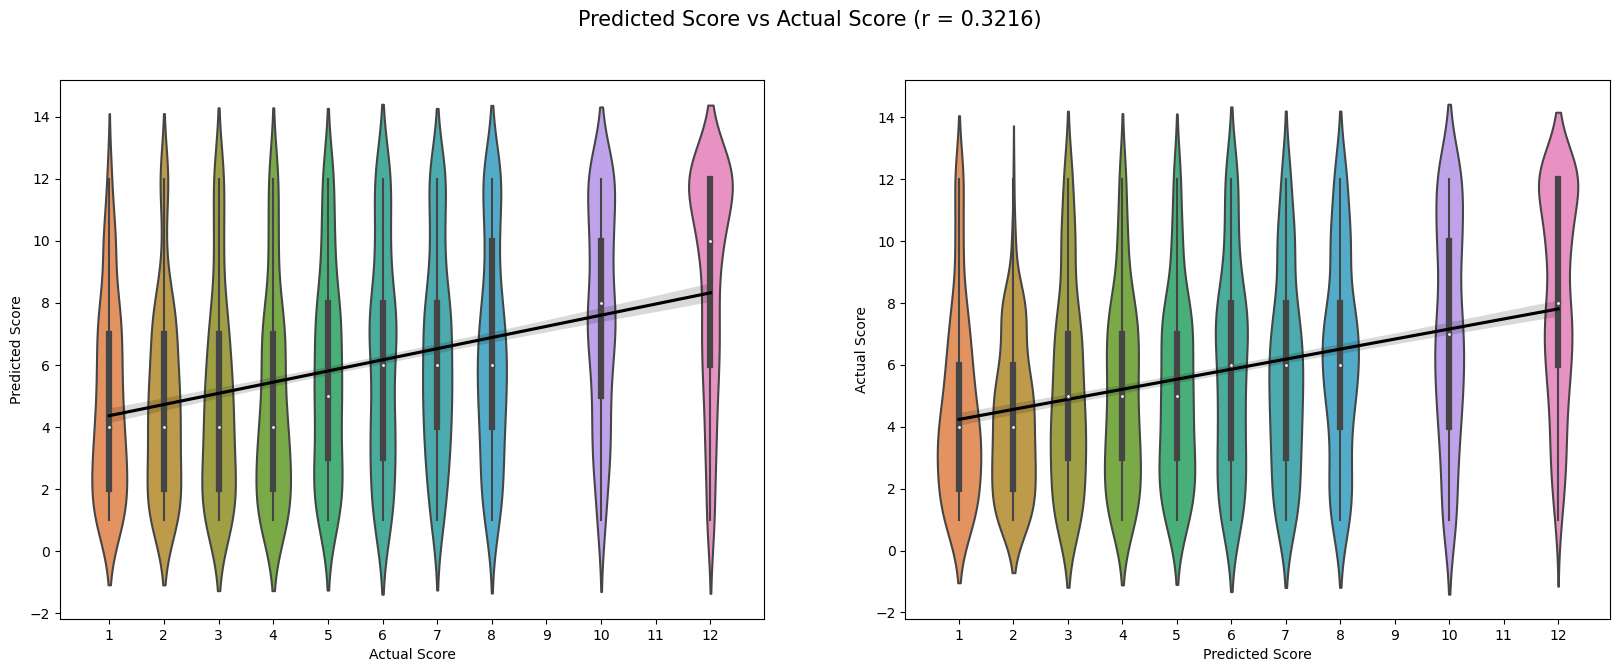

In [21]:
xgbf.violins(predictions)

So, compared to the pairwise ranked version, this is not very good. 

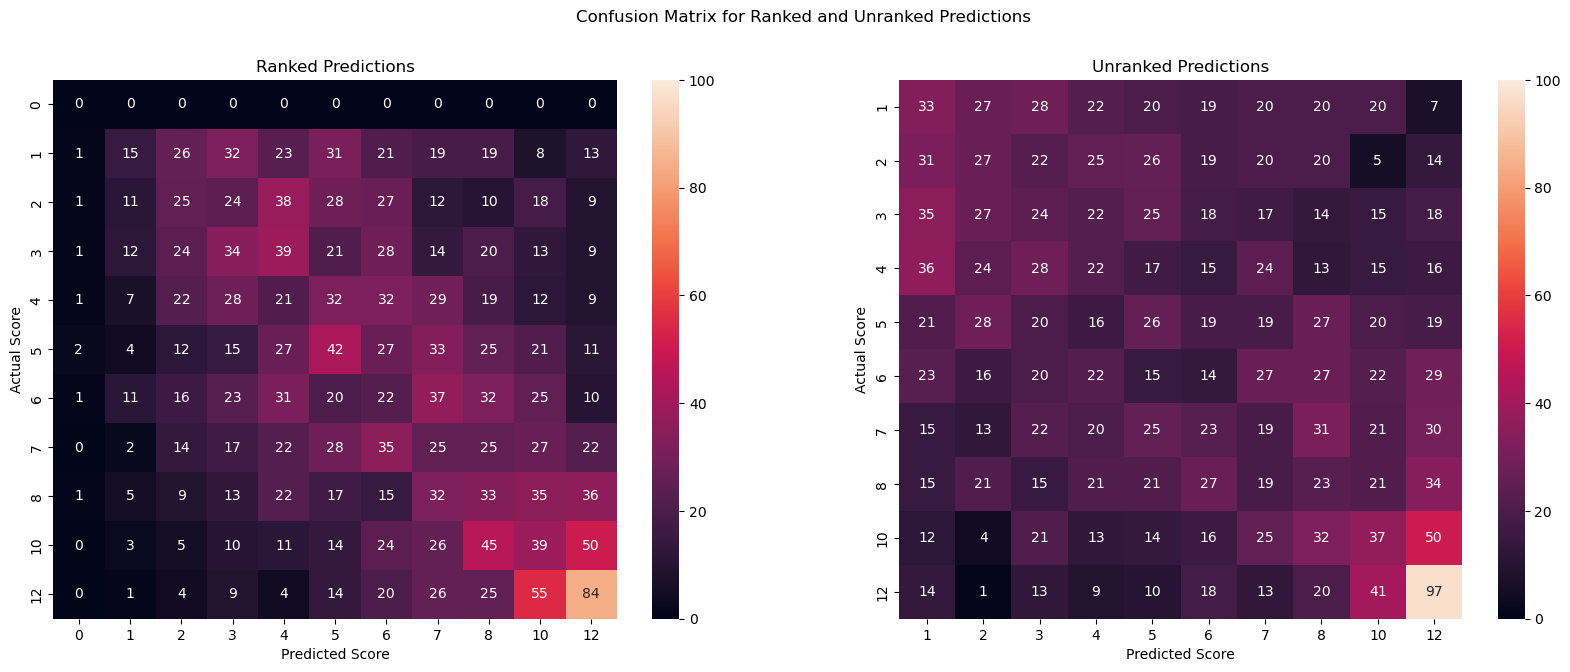

In [22]:
# ranked and unranked plot side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
fig.suptitle('Confusion Matrix for Ranked and Unranked Predictions')

# ranked plot
xgbf.cm_heatmap(out, title='Ranked Predictions', ax=ax1)
xgbf.cm_heatmap(predictions, title='Unranked Predictions', ax=ax2)



# Combined the hurdle models

Create the train-test split based on votingCountry*year (we will call this the id column)

In [23]:
df_xgboost.head()

,Year,From country,Votes,Own,English,Other,has_border,code,prop_emigrants,Gender,comps_since_last_win,received_vote
0,1999,AT,12.0,0.0,0.0,1.0,0.0,BA,-0.376727,group,0.682540,1
1,1999,AT,0.0,0.0,1.0,0.0,0.0,BE,0.141040,female,0.190476,0
2,1999,AT,0.0,1.0,0.0,0.0,0.0,CY,0.000310,female,0.682540,0
3,1999,AT,10.0,0.0,0.0,1.0,1.0,DE,1.013074,group,0.253968,1
4,1999,AT,5.0,0.0,1.0,0.0,0.0,DK,0.205615,group,0.555556,1


In [24]:
df_xgboost['id'] = df_xgboost['From country'] + df_xgboost['Year'].astype(str)

df_xgboost['rank'] = df_xgboost['Votes']

df_xgboost['rank'] = df_xgboost['rank'].apply(lambda x: 9 if x == 10 else x)
df_xgboost['rank'] = df_xgboost['rank'].apply(lambda x: 10 if x == 12 else x)

#df_xgboost['rank'].value_counts()
df_xgboost['rank'] = df_xgboost['rank'].astype(int)


/var/folders/c2/_b9mpch10xs9cgrc8sq6fhfm0000gr/T/ipykernel_93674/1522202486.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xgboost['id'] = df_xgboost['From country'] + df_xgboost['Year'].astype(str)
/var/folders/c2/_b9mpch10xs9cgrc8sq6fhfm0000gr/T/ipykernel_93674/1522202486.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xgboost['rank'] = df_xgboost['Votes']
/var/folders/c2/_b9mpch10xs9cgrc8sq6fhfm0000gr/T/ipykernel_93674/1522202486.py:5: SettingWithCopyWarning: 
A value is trying to be set o

In [25]:
df_hurdle = df_xgboost.copy()

df_hurdle['has_border'] = df_hurdle['has_border'].fillna(0)

df_hurdle.head()

,Year,From country,Votes,Own,English,Other,has_border,code,prop_emigrants,Gender,comps_since_last_win,received_vote,id,rank
0,1999,AT,12.0,0.0,0.0,1.0,0.0,BA,-0.376727,group,0.682540,1,AT1999,10
1,1999,AT,0.0,0.0,1.0,0.0,0.0,BE,0.141040,female,0.190476,0,AT1999,0
2,1999,AT,0.0,1.0,0.0,0.0,0.0,CY,0.000310,female,0.682540,0,AT1999,0
3,1999,AT,10.0,0.0,0.0,1.0,1.0,DE,1.013074,group,0.253968,1,AT1999,9
4,1999,AT,5.0,0.0,1.0,0.0,0.0,DK,0.205615,group,0.555556,1,AT1999,5


In [26]:
# one hot encode the gender, from country and code
for j in ['Gender', 'code', 'From country']:
    j_text = "_voting" if j == 'From country' else ''
    for i in df_hurdle[j].unique():
        df_hurdle[i+j_text] = df_hurdle[j].apply(lambda x: 1 if x == i else 0)

    df_hurdle = df_hurdle[df_hurdle.columns.drop(j)]

#df2= df2[df2.columns.drop('From country')]
df_hurdle= df_hurdle[df_hurdle.columns.drop('Year')]

df_hurdle.head()

,Votes,Own,English,Other,has_border,prop_emigrants,comps_since_last_win,received_vote,id,rank,...,AM_voting,CZ_voting,GE_voting,ME_voting,RS_voting,AZ_voting,SM_voting,SK_voting,IT_voting,AU_voting
0,12.0,0.0,0.0,1.0,0.0,-0.376727,0.682540,1,AT1999,10,...,0,0,0,0,0,0,0,0,0,0
1,0.0,0.0,1.0,0.0,0.0,0.141040,0.190476,0,AT1999,0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,1.0,0.0,0.0,0.0,0.000310,0.682540,0,AT1999,0,...,0,0,0,0,0,0,0,0,0,0
3,10.0,0.0,0.0,1.0,1.0,1.013074,0.253968,1,AT1999,9,...,0,0,0,0,0,0,0,0,0,0
4,5.0,0.0,1.0,0.0,0.0,0.205615,0.555556,1,AT1999,5,...,0,0,0,0,0,0,0,0,0,0


In [27]:
df_hurdle.loc[df_hurdle['id'] == 'AD2004']

,Votes,Own,English,Other,has_border,prop_emigrants,comps_since_last_win,received_vote,id,rank,...,AM_voting,CZ_voting,GE_voting,ME_voting,RS_voting,AZ_voting,SM_voting,SK_voting,IT_voting,AU_voting
2541,0.0,1.0,0.0,0.0,0.0,-2.747045,0.587302,0,AD2004,0,...,0,0,0,0,0,0,0,0,0,0
2542,1.0,0.0,1.0,0.0,0.0,-3.298217,0.269841,1,AD2004,1,...,0,0,0,0,0,0,0,0,0,0
2543,12.0,1.0,0.0,0.0,1.0,-0.230052,0.539683,1,AD2004,10,...,0,0,0,0,0,0,0,0,0,0
2544,7.0,0.0,0.0,1.0,1.0,-0.943714,0.412698,1,AD2004,7,...,0,0,0,0,0,0,0,0,0,0
2545,0.0,1.0,1.0,0.0,0.0,-2.176209,0.095238,0,AD2004,0,...,0,0,0,0,0,0,0,0,0,0
2546,8.0,0.0,1.0,0.0,0.0,-2.385034,0.761905,1,AD2004,8,...,0,0,0,0,0,0,0,0,0,0
2547,0.0,1.0,1.0,0.0,0.0,-2.134969,0.111111,0,AD2004,0,...,0,0,0,0,0,0,0,0,0,0
2548,0.0,0.0,1.0,0.0,0.0,-3.298217,0.761905,0,AD2004,0,...,0,0,0,0,0,0,0,0,0,0
2549,0.0,0.0,1.0,0.0,0.0,-3.298217,0.444444,0,AD2004,0,...,0,0,0,0,0,0,0,0,0,0
2550,0.0,0.0,1.0,0.0,0.0,-3.298217,0.126984,0,AD2004,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import train_test_split

# select a random sample of 33% of the unique values of df_hurdle['id']
test_groups = np.random.choice(df_hurdle['id'].unique(), size=int(len(df_hurdle['id'].unique())*0.33), replace=False)
train_groups = np.setdiff1d(df_hurdle['id'].unique(), test_groups)

train_data = df_hurdle.loc[df_hurdle['id'].isin(train_groups)]
test_data = df_hurdle.loc[df_hurdle['id'].isin(test_groups)]

X_train = train_data.loc[:, ~train_data.columns.isin(['id','rank', 'Votes', 'received_vote'])]
y_train = train_data.loc[:, train_data.columns.isin(['received_vote'])]

X_test = test_data.loc[:, ~test_data.columns.isin(['id','rank', 'Votes', 'received_vote'])]
y_test = test_data.loc[:, test_data.columns.isin(['received_vote'])]


DE2015    25
RU2015    25
DE2017    25
DE2014    24
MD2016    24
          ..
AD2006    12
AD2005    11
SM2012    11
AD2007    11
SM2016    10
Name: id, Length: 252, dtype: int64
SM2015    12
MC2005    12
AD2006    12
Name: id, dtype: int64


In [29]:
model = xgb.XGBClassifier()
hurdle1_model = model.fit(X_train, y_train)

In [30]:
hurdle1_df = xgbf.model_predictions(hurdle1_model, X_test,  y_test)

# merge test_data and hurdle1_df
cols = [i for i in test_data.columns if i not in hurdle1_df.columns]
hurdle1_df = pd.merge(hurdle1_df, test_data[cols], left_index=True, right_index=True)

hurdle1_df.head()


,Own,English,Other,has_border,prop_emigrants,comps_since_last_win,group,female,male,BA,...,SM_voting,SK_voting,IT_voting,AU_voting,predictions,actual,Votes,received_vote,id,rank
0,0.0,0.0,1.0,0.0,-0.376727,0.682540,1,0,0,1,...,0,0,0,0,0,1,12.0,1,AT1999,10
1,0.0,1.0,0.0,0.0,0.141040,0.190476,0,1,0,0,...,0,0,0,0,0,0,0.0,0,AT1999,0
2,1.0,0.0,0.0,0.0,0.000310,0.682540,0,1,0,0,...,0,0,0,0,0,0,0.0,0,AT1999,0
3,0.0,0.0,1.0,1.0,1.013074,0.253968,1,0,0,0,...,0,0,0,0,1,1,10.0,1,AT1999,9
4,0.0,1.0,0.0,0.0,0.205615,0.555556,1,0,0,0,...,0,0,0,0,1,1,5.0,1,AT1999,5


Accuracy: 75.23%


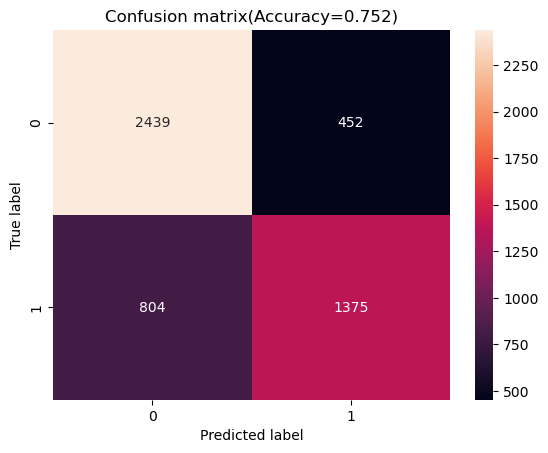

In [31]:
xgbf.model_evalutation(hurdle1_df)

In [32]:
hurdle1_df.head()

,Own,English,Other,has_border,prop_emigrants,comps_since_last_win,group,female,male,BA,...,SM_voting,SK_voting,IT_voting,AU_voting,predictions,actual,Votes,received_vote,id,rank
0,0.0,0.0,1.0,0.0,-0.376727,0.682540,1,0,0,1,...,0,0,0,0,0,1,12.0,1,AT1999,10
1,0.0,1.0,0.0,0.0,0.141040,0.190476,0,1,0,0,...,0,0,0,0,0,0,0.0,0,AT1999,0
2,1.0,0.0,0.0,0.0,0.000310,0.682540,0,1,0,0,...,0,0,0,0,0,0,0.0,0,AT1999,0
3,0.0,0.0,1.0,1.0,1.013074,0.253968,1,0,0,0,...,0,0,0,0,1,1,10.0,1,AT1999,9
4,0.0,1.0,0.0,0.0,0.205615,0.555556,1,0,0,0,...,0,0,0,0,1,1,5.0,1,AT1999,5


In [33]:
df2 = hurdle1_df.loc[hurdle1_df['predictions'] > 0]

# remove predictions, actual and received_vote columns
df2 = df2[df2.columns.drop(['predictions', 'actual', "Votes", 'received_vote'])]

print(df2['rank'].value_counts())

#df2 = df2.rename(columns={"Votes": 'rank'})
#df2 = df2.rename(columns={"From country": 'id'})

#df2['rank'] = df2['rank'].astype(int) - 1


# select a random sample of 33% of the unique values of df_hurdle['id']
test_groups = np.random.choice(df2['id'].unique(), size=int(len(df2['id'].unique())*0.33), replace=False)
train_groups = np.setdiff1d(df2['id'].unique(), test_groups)

train_data = df2.loc[df2['id'].isin(train_groups)]
test_data = df2.loc[df2['id'].isin(test_groups)]

X_train = train_data.loc[:, ~train_data.columns.isin(['id','rank', 'Votes', 'received_vote'])]
y_train = train_data.loc[:, train_data.columns.isin(['rank'])]

X_test = test_data.loc[:, ~test_data.columns.isin(['id','rank', 'Votes', 'received_vote'])]
y_test = test_data.loc[:, test_data.columns.isin(['rank'])]

print(test_data['id'].value_counts())
print(train_data['id'].value_counts())

groups = train_data.groupby('id').size().to_frame('size')['size'].to_numpy()

model_ranked = xgb.XGBRanker(  
    tree_method='hist',
    booster='gbtree',
    objective='rank:pairwise',
    random_state=7, 
    learning_rate=0.1,
    colsample_bytree=0.9, 
    eta=0.05, 
    max_depth=6, 
    n_estimators=110, 
    subsample=0.75 
)

model_ranked.fit(X_train, y_train, group=groups, verbose=True)

# return model, test_data, train_data

0     452
10    208
9     196
8     168
7     151
6     143
5     130
3     116
4     104
1      82
2      77
Name: rank, dtype: int64
FI2017    11
DK2000    11
CY2003    11
RO2002    11
LT2018    10
          ..
BA2006     4
NL2013     3
BE2011     3
ME2014     3
ME2013     2
Name: id, Length: 83, dtype: int64
GR2017    12
PL2017    12
HR2019    11
DE2007    11
UA2010    11
          ..
SK2012     4
ME2009     3
HR2013     3
MK2013     2
MC2004     2
Name: id, Length: 169, dtype: int64


XGBRanker(base_score=None, booster='gbtree', callbacks=None,
          colsample_bylevel=None, colsample_bynode=None, colsample_bytree=0.9,
          early_stopping_rounds=None, enable_categorical=False, eta=0.05,
          eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
          grow_policy=None, importance_type=None, interaction_constraints=None,
          learning_rate=0.1, max_bin=None, max_cat_threshold=None,
          max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
          max_leaves=None, min_child_weight=None, missing=nan,
          monotone_constraints=None, n_estimators=110, n_jobs=None,
          num_parallel_tree=None, predictor=None, ...)

In [34]:
#model_ranked, test_data, train_data = xgboost_rank_model(hurdle_input, seed=7, test_size=0.33)
#model_ranked, test_data, train_data = xgbf.xgboost_rank_model(hurdle_input, seed=42, test_size=0.33)
#predictions2 = xgbf.ranked_model_predictions(model_ranked, test_data)

from scipy.stats import rankdata
from sklearn.metrics import accuracy_score

test = test_data.copy()

test['prediction_rel'] = np.nan
test['predictions'] = np.nan

for i in test['id'].unique():
    sub_test = test.loc[test['id'] == i, ~test.columns.isin(['id', 'rank', 'prediction_rel', 'predictions'])]

    preds = model.predict(sub_test)

    # get the order of the predictions 
    res = rankdata(preds, method='ordinal')
    test.loc[test['id'] == i, 'prediction_rel'] = res

    # create a score for top 10 predictions getting 1:10 and others 0
    top10 = test.loc[test['id'] == i, 'prediction_rel'].nlargest(10).values


    test.loc[test['id'] == i, 'predictions'] = test.loc[test['id'] == i, 'prediction_rel'].apply(lambda x: x if x in top10 else 0)
    
    # if not zero subtract min(top10) 
    test.loc[test['id'] == i, 'predictions'] = test.loc[test['id'] == i, 'predictions'].apply(lambda x: x - max(top10) + 10 if x != 0 else 0)

    # if 10 set to 12
    #test.loc[test['id'] == i, 'predictions'] = test.loc[test['id'] == i, 'predictions'].apply(lambda x: 12 if x == 10 else x)
    #test.loc[test['id'] == i, 'predictions'] = test.loc[test['id'] == i, 'predictions'].apply(lambda x: 10 if x == 9 else x)

test['actual'] = test['rank'] 


accuracy = accuracy_score(test['actual'], test['predictions'])
print("Accuracy: %.2f%%" % (accuracy * 100.0))

predictions2 = test

Accuracy: 9.83%


In [35]:
predictions2['actual'].value_counts()
#predictions2['predictions'].value_counts()

0     144
10     67
9      61
8      56
6      51
7      49
5      42
3      41
4      36
1      27
2      26
Name: actual, dtype: int64

In [36]:
hurdle1_df.head()

,Own,English,Other,has_border,prop_emigrants,comps_since_last_win,group,female,male,BA,...,SM_voting,SK_voting,IT_voting,AU_voting,predictions,actual,Votes,received_vote,id,rank
0,0.0,0.0,1.0,0.0,-0.376727,0.682540,1,0,0,1,...,0,0,0,0,0,1,12.0,1,AT1999,10
1,0.0,1.0,0.0,0.0,0.141040,0.190476,0,1,0,0,...,0,0,0,0,0,0,0.0,0,AT1999,0
2,1.0,0.0,0.0,0.0,0.000310,0.682540,0,1,0,0,...,0,0,0,0,0,0,0.0,0,AT1999,0
3,0.0,0.0,1.0,1.0,1.013074,0.253968,1,0,0,0,...,0,0,0,0,1,1,10.0,1,AT1999,9
4,0.0,1.0,0.0,0.0,0.205615,0.555556,1,0,0,0,...,0,0,0,0,1,1,5.0,1,AT1999,5


In [37]:
#refactor the countries for the first hurdle

p1 = hurdle1_df.copy()


cols = [col for col in p1.columns if '_voting' in col]
cols2 = [col for col in p1.columns if '_voting' not in col]


# wide format _voting columns to long format
hurdle_input2 = pd.melt(p1, id_vars=cols2, 
                       value_vars= cols, var_name='From country')

hurdle_input2 = hurdle_input2.loc[hurdle_input2['value'] ==1]


p1['From country'] = hurdle_input2['From country'].str.replace('_voting', '').tolist()
p1 = p1.drop(cols, axis=1)


cols2 = ['Own', 'English', 'Other', 'has_border', 'prop_emigrants',
         'rank', 'received_vote', 'id', 'From country', 'Votes',
       'comps_since_last_win', 'group', 'female', 'male', 'predictions', 'actual']
cols = [col for col in p1.columns if col not in cols2]


hurdle_input4 = pd.melt(p1, id_vars=cols2, 
                       value_vars= cols, var_name='code')

hurdle_input4 = hurdle_input4.loc[hurdle_input4['value'] == 1]

# add hurdle_input2['From country'] to hurdle_input

p1['code'] = hurdle_input4['code'].tolist()

predictions1 = p1

In [38]:
pred1 = predictions1.loc[predictions1['predictions'] == 0]

#print(pred1['actual'].value_counts())

pred1 = pred1[['predictions', 'rank', 'id']] # , 'code', 'From country'

# rename Votes as actual
pred1 = pred1.rename(columns={"rank": 'actual'})

pred2 = predictions2[['predictions', 'actual', 'id']]

# order by id
pred2 = pred2.sort_values(by=['id'])

#pred2 = pred2.rename(columns={"rank": 'actual'})

# pred2['code'] = pred2['id'].str[:2]
# pred2['Year'] = pred2['id'].str[-4:]
# pred2 = pred2.drop(columns=['id'])

pred2.head(20)


,predictions,actual,id
4549,6.0,0,AD2007
4550,7.0,0,AD2007
4552,8.0,8,AD2007
4553,9.0,0,AD2007
4557,10.0,0,AD2007
13710,5.0,9,AL2018
13720,8.0,10,AL2018
13713,7.0,3,AL2018
13711,6.0,8,AL2018
13707,4.0,0,AL2018


In [39]:
# combine the two dataframes
predictions_final = pd.concat([pred1, pred2])


predictions_final.head()

,predictions,actual,id
0,0.0,10,AT1999
1,0.0,0,AT1999
2,0.0,0,AT1999
6,0.0,0,AT1999
7,0.0,0,AT1999


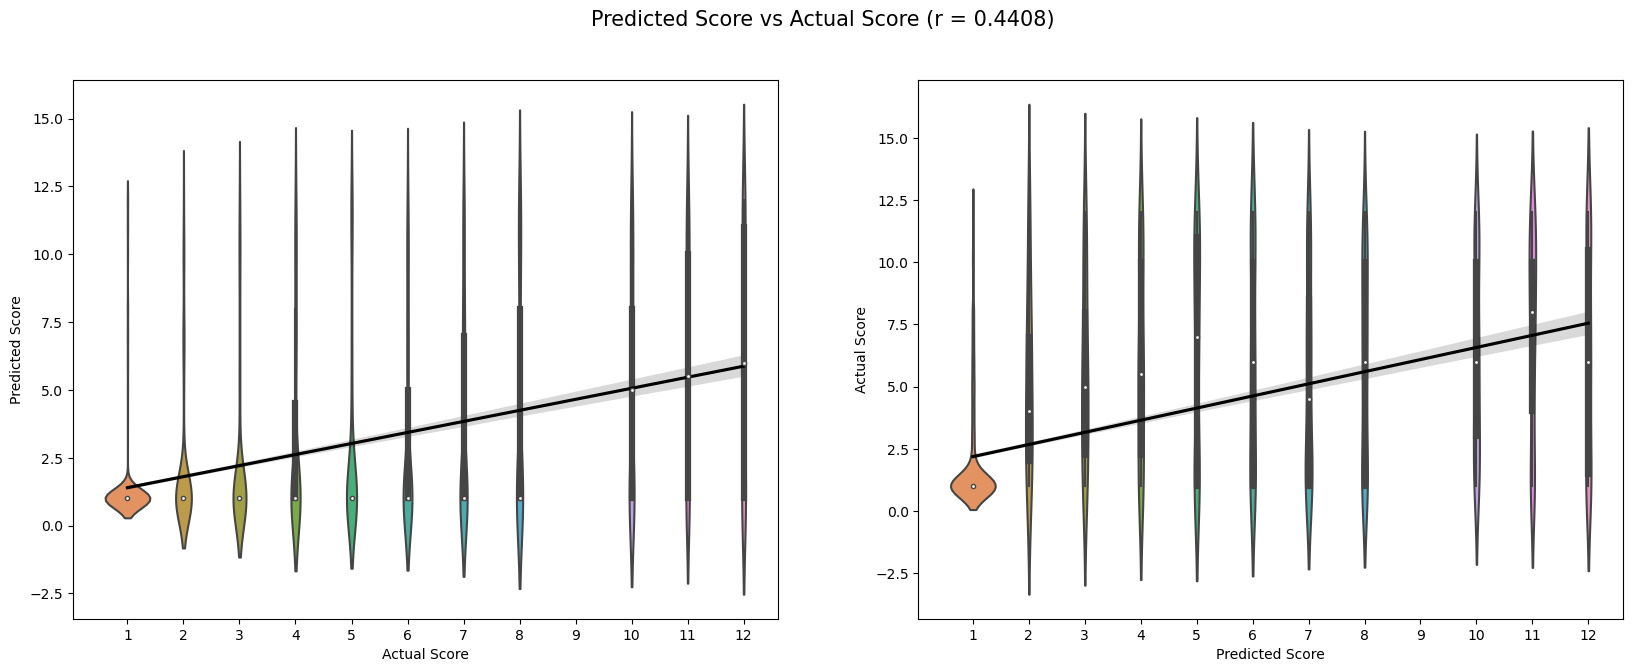

In [40]:
xgbf.violins(predictions_final)

In [41]:
predictions2['actual'].value_counts()

0     144
10     67
9      61
8      56
6      51
7      49
5      42
3      41
4      36
1      27
2      26
Name: actual, dtype: int64

In [42]:
predictions2['predictions'].value_counts()

9.0     83
10.0    83
8.0     82
7.0     79
6.0     76
5.0     66
4.0     54
3.0     38
2.0     22
1.0     13
0.0      4
Name: predictions, dtype: int64

11


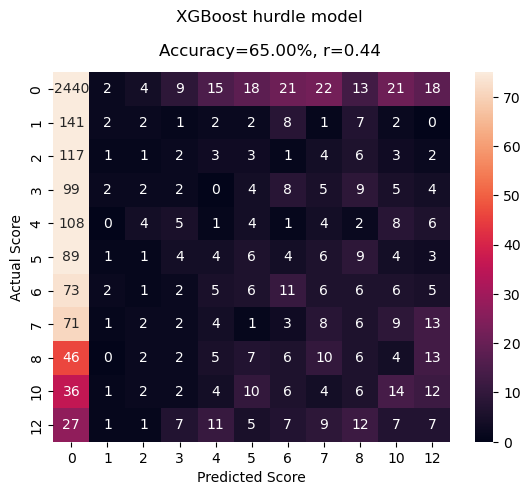

In [43]:
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.stats import spearmanr

# confusion matrix for hurdle model

# evaluate predictions
accuracy = accuracy_score(predictions_final['predictions'], predictions_final['actual'])

cm = confusion_matrix(y_true=predictions_final['actual'], y_pred=predictions_final['predictions'])
plot = sns.heatmap(cm, annot=True, fmt='g', vmin=0, vmax=75)

print(len(cm[[0]][0]))

if(len(cm[[0]][0]) == 11) : 
# change the tick labels
    plot.set_xticks(np.arange(0, 11, 1)+0.5, np.arange(0, 9, 1).tolist() + [10, 12])
    plot.set_yticks(np.arange(0, 11, 1)+0.5, np.arange(0, 9, 1).tolist() + [10, 12])
else: 
    plot.set_xticks(np.arange(0, 10, 1)+0.5, np.arange(1, 9, 1).tolist() + [10, 12])
    plot.set_yticks(np.arange(0, 10, 1)+0.5, np.arange(1, 9, 1).tolist() + [10, 12])

# spearman correlation
corr, p = spearmanr(predictions_final['actual'], predictions_final['predictions'])

plot.text(x=6, y=-1.5, s= "XGBoost hurdle model", fontsize=12, ha="center")
plot.text(x=6, y=-0.5, s= "Accuracy=%.2f%%, r=%.2f"% (accuracy * 100.0, corr), fontsize=12, ha="center")
plot.set_ylabel('Actual Score')
plot.set_xlabel('Predicted Score')

plt.show()


First hurdle : predict if zero - first column

If not zero, we predict the score but don't let it equal zero. 

In [ ]:
predictions1['Year'].value_counts()